Before jumping into model selection, I wanted to see what the population size trajectories looked like in order to choose an appropriate parametric coalescent model.
The analyses reported here were conducted under a GTR model of sequence evolution, with 3 codon partitions and a relaxed uncorrelated log-normal clock.
I ran 3 chains for 100 million iterations each for each serotype.
The results used here are of the seed that gave the highest ESS across the board. 
I have employed a Gumbel type II prior on the Skygrid precision but results are quite similar when using the default Gamma prior. 

In [30]:
get_skygrid_for_plot <- function(dt){
    return(
        dt[,  grep("logPopSize", names(dt))]
    )
}
#####
overlay_pop_sizes <- function(logs, youngest, cutOff, group_name = NULL){
  require(coda)  
  require(ggplot2)
  number_ticks <- function(n) {function(limits) pretty(limits, n)}
  ## 'logs' is a  **named** list of subsetted log files with the parameters of interest (popSizes)
  L <- length(logs)
  if(length(youngest) < L){
      warning("supplied youngest not of right dimension, replicating \n")
      youngest <- rep(youngest, L)
  }
  if(length(cutOff) < L){
      warning("supplied cutOff not of right dimension, replicating \n")
      cutOff <- rep(cutOff, L)
  } 
  M <- unlist(lapply(logs, ncol))
  ## Compute median and HPDs
  summaries <- lapply(logs, function(ll) {
    res <- cbind( apply(ll, 2, median), coda::HPDinterval(coda::as.mcmc(ll)))
    colnames(res) <- c("median", "lower", "upper")
    return(res)
  } )
  ## create ages and groups
  for(i in 1:L){
    summaries[[i]] <- data.frame(summaries[[i]], group = names(logs)[i],
                                 time = seq(youngest[i], youngest[i]-cutOff[i], length.out = M[i]) ) 
  } 
  forPlot <- do.call(rbind, summaries)
  if(is.null(group_name)) group_name <- "group"
  p <- ggplot(forPlot, aes( x = time, y = median, colour = group, fill = group)) + 
    geom_line() +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = .2)+ 
    labs(fill = group_name, color = group_name) +
    scale_x_continuous("Time (years)", breaks = number_ticks(10)) + 
    scale_y_continuous("Log population size", expand = c(0, 0)) + 
    theme_bw() + 
    theme(axis.text.x = element_text(face="bold", size = 14),
          axis.text.y = element_text(face="bold", size = 14),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          axis.title = element_text(size = 14),
          legend.title = element_text(size = 14),
          legend.text=element_text(size = 14))
return(p)  
}

In [4]:
burnin <- .2

fmdv_A <- read.table("../../DATA/BEAST_OUTPUT/FMDV_serotype_A_skygrid.log", header = TRUE)
fmdv_A <- fmdv_A[round(burnin * nrow(fmdv_A)):nrow(fmdv_A), ]

fmdv_O <- read.table("../../DATA/BEAST_OUTPUT/FMDV_serotype_O_skygrid.log", header = TRUE)
fmdv_O <- fmdv_O[round(burnin * nrow(fmdv_O)):nrow(fmdv_O), ]


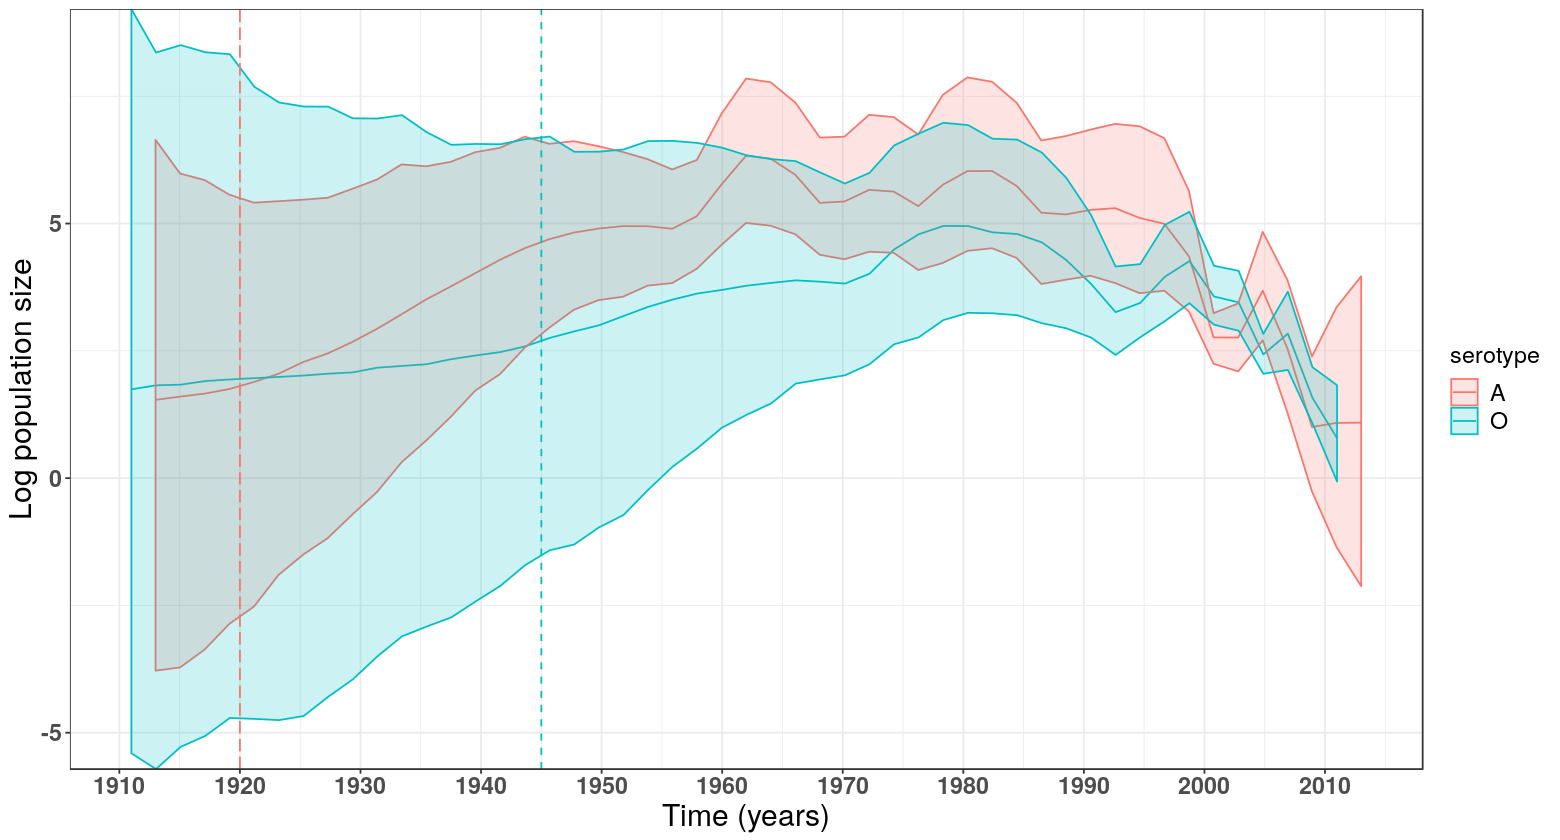

In [31]:
logs_FMDV <- list(
    A = get_skygrid_for_plot(fmdv_A),
    O = get_skygrid_for_plot(fmdv_O)
)
Popplot <- overlay_pop_sizes(logs = logs_FMDV,
                             youngest = c(2013, 2011), cutOff = c(100, 100), group_name = "serotype")
gg_color_hue <- function(n) { ## https://stackoverflow.com/questions/8197559/emulate-ggplot2-default-color-palette
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}
options(repr.plot.width = 13, repr.plot.height = 7)
Popplot +
geom_vline(xintercept = 1945, linetype = "dashed", colour = gg_color_hue(2)[-1]) + ## adding approximate root heights
geom_vline(xintercept = 1920, linetype = "longdash", colour = gg_color_hue(1)) 

### Including case data

In [14]:
fmd.cases <- read.table("../../DATA/EPI_DATA/cases_FMD.txt", header = TRUE, sep = "\t")

In [17]:
cases.dt <- reshape2::melt(fmd.cases, id = c("Year"),
                       variable.name = "serotype", value.name = "cases")

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”`geom_smooth()` using method = 'loess' and formula 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”

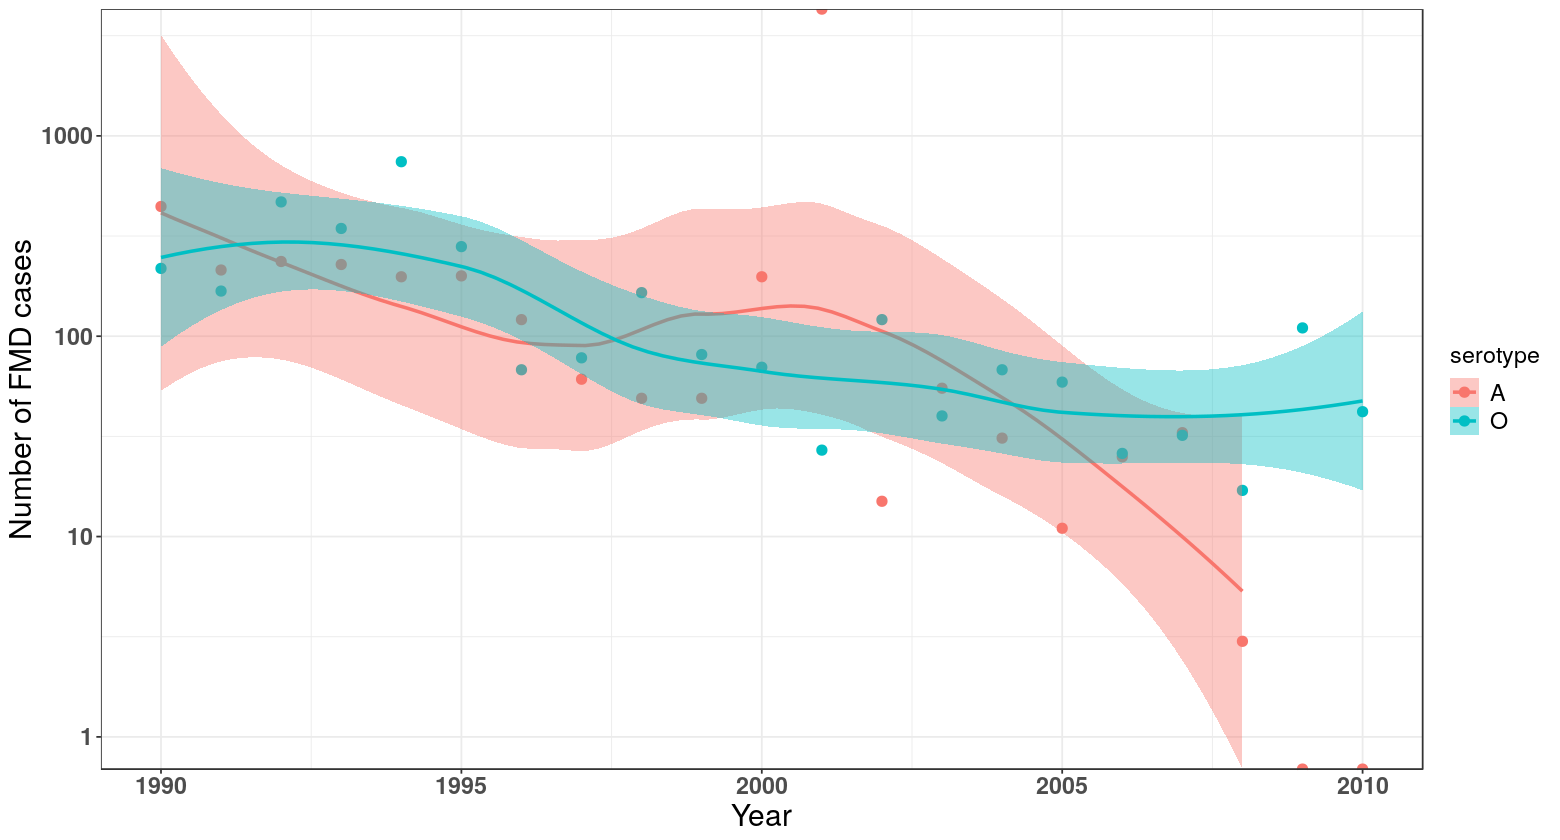

In [35]:
ggplot(subset(cases.dt, serotype != "C"), aes(x = Year, y = cases, fill = serotype, colour = serotype)) +
#     geom_line(size = 1.2) +
    geom_point(size = 2.5) +
    scale_y_log10("Number of FMD cases", expand = c(0, 0)) +
geom_smooth() + 
    theme_bw() + 
    theme(axis.text.x = element_text(face="bold", size = 14),
          axis.text.y = element_text(face="bold", size = 14),
          axis.title.x = element_text(size = 18),
          axis.title.y = element_text(size = 18),
          axis.title = element_text(size = 14),
          legend.title = element_text(size = 14),
          legend.text=element_text(size = 14)) + 
NULL